### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

### Read/Transform Data

In [2]:
#read data
fake_news=pd.read_csv('Fake.csv')
true_news=pd.read_csv('True.csv')

In [3]:
#join and shuffle data
fake_news['label']=0
true_news['label']=1
data = pd.concat([fake_news,true_news])
data = data.sample(frac=1).reset_index(drop=True) #sample shuffles the data
data.head()

,title,text,subject,date,label
0,(VIDEO) JUSTICE DEPARTMENT AND FBI CLASH ON WH...,The FBI defines terrorism as the unlawful use...,Government News,"Jun 21, 2015",0
1,CHAOS: Sarah Palin Promises To Lead GOP Revol...,Failed Republican vice-presidential candidate ...,News,"April 16, 2016",0
2,WATCH FUNNIEST MAN In American Politics Ridicu...,You don t want to miss this!Here s a little in...,politics,"Dec 31, 2015",0
3,Trump Was Just Busted For Daydreaming At G20 ...,"The last time Donald Trump went overseas, it w...",News,"July 7, 2017",0
4,TODAY: LIST OF U.S. CITIES Where “DAY OF RAGE”...,Isn t it great when the day after a major terr...,left-news,"Jul 15, 2016",0


<AxesSubplot:title={'center':'Distribution of fake news per news type'}, xlabel='News Type', ylabel='Number of News'>

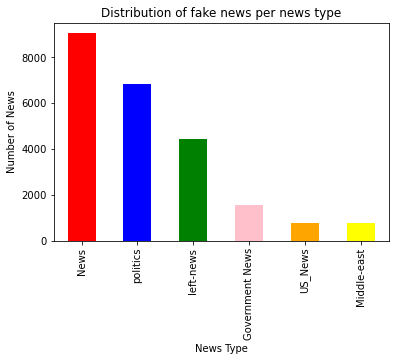

In [4]:
fake_news['subject'].value_counts().plot.bar(color=['red','blue','green','pink','orange','yellow','cyan','black'], title="Distribution of fake news per news type", xlabel="News Type", ylabel="Number of News")

<AxesSubplot:title={'center':'Distribution of true news per news type'}, xlabel='News Type', ylabel='Number of News'>

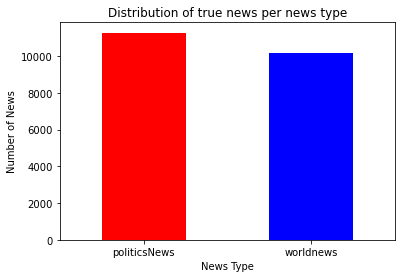

In [5]:
true_news['subject'].value_counts().plot.bar(color=['red','blue','green','pink','orange','yellow','cyan','black'], title="Distribution of true news per news type", xlabel="News Type", ylabel="Number of News", rot=0)

Number of fake news: 23481
Number of true news: 21417


<AxesSubplot:title={'center':'Distribution per class'}, xlabel='Class', ylabel='Number of News'>

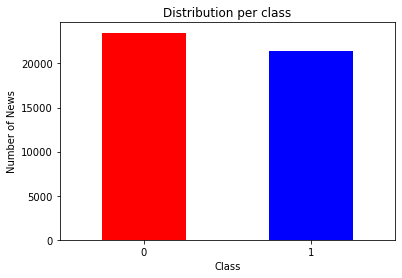

In [6]:
print("Number of fake news:", len(fake_news))
print("Number of true news:", len(true_news))
data['label'].value_counts().plot.bar(color=['red','blue'], title="Distribution per class", xlabel="Class", ylabel="Number of News",rot=0)

<AxesSubplot:title={'center':'Distribution of news per news type'}, xlabel='News Type', ylabel='Number of News'>

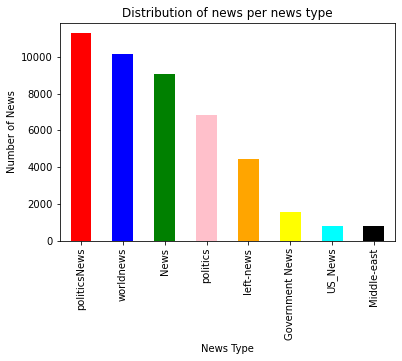

In [7]:
data['subject'].value_counts().plot.bar(color=['red','blue','green','pink','orange','yellow','cyan','black'], title="Distribution of news per news type", xlabel="News Type", ylabel="Number of News")

In [8]:
x = np.array(data['title']) #"text"
y = np.array(data['label'])

In [9]:
# tokenizer to transform text into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=100000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(x)

#Transforms each text in x to a sequence of integers.
x = tokenizer.texts_to_sequences(x)

#Pads sequences to the same length. In this case, with maxlen of 100 integers
x = pad_sequences(x, maxlen = 20)

### Models

In [10]:
def LSTM_Model(vocab_size=100000, features=50, input_length=20, learning_rate=0.002, dropout=0.5):
    model=Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size,features,input_length=input_length))
    # Long Short Term Memory layer
    model.add(LSTM(100, dropout=dropout))
    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [11]:
def CNN_Model(vocab_size=100000, features=50, input_length=20, learning_rate=0.001, kernel_size=8):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size,features,input_length=input_length))
    # Convolutional Layer
    model.add(Conv1D(128, kernel_size, strides=1, activation='relu'))
    # Pooling Layer
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [12]:
def cross_validationLSTM(x, y, learning_rate=0.002, n_epochs=2, dropout=0.5):
    results = []
    
    #split into k folds and fit k times
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LSTM_Model(learning_rate=learning_rate, dropout=dropout)
        res = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=n_epochs,batch_size=64)
        results.append(res)
    
    #calculate results
    results_acc = []
    results_val_acc = []
    results_loss = []
    results_val_loss = []
    for i in range(n_epochs):
        #get the med value
        acc = sum([res.history['accuracy'][i] for res in results])/len(results)
        val_acc = sum([res.history['val_accuracy'][i] for res in results])/len(results)
        loss = sum([res.history['loss'][i] for res in results])/len(results)
        val_loss = sum([res.history['val_loss'][i] for res in results])/len(results)
        
        #adding to array
        results_acc.append(acc)
        results_val_acc.append(val_acc)
        results_loss.append(loss)
        results_val_loss.append(val_loss)

    return results_acc, results_val_acc, results_loss, results_val_loss

In [13]:
def cross_validationCNN(x, y, learning_rate=0.001, n_epochs=2, kernel_size=8):
    results = []
    
    #split into k folds and fit k times
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = CNN_Model(learning_rate=learning_rate, kernel_size=kernel_size)
        res = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=n_epochs,batch_size=64)
        results.append(res)
    
    #calculate results
    results_acc = []
    results_val_acc = []
    results_loss = []
    results_val_loss = []
    for i in range(n_epochs):
        #get the med value
        acc = sum([res.history['accuracy'][i] for res in results])/len(results)
        val_acc = sum([res.history['val_accuracy'][i] for res in results])/len(results)
        loss = sum([res.history['loss'][i] for res in results])/len(results)
        val_loss = sum([res.history['val_loss'][i] for res in results])/len(results)
        
        #adding to array
        results_acc.append(acc)
        results_val_acc.append(val_acc)
        results_loss.append(loss)
        results_val_loss.append(val_loss)

    return results_acc, results_val_acc, results_loss, results_val_loss

In [14]:
def plot_acc_valacc(results_acc, results_val_acc):
    print(results_val_acc)
    plt.figure(figsize = (18,7))
    plt.plot(range(1, len(results_acc)+1), results_acc, color="#cec635")
    plt.plot(range(1, len(results_acc)+1), results_val_acc, color="#da2700")
    plt.xticks(range(1, len(results_acc)+1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title("Training/Validation Accuracy Comparison")
    plt.show()

In [15]:
def plot_loss_valloss(results_loss, results_val_loss):
    print(results_val_loss)
    plt.figure(figsize = (18,7))
    plt.plot(range(1, len(results_loss)+1), results_loss, color="#cec635")
    plt.plot(range(1, len(results_loss)+1), results_val_loss, color="#da2700")
    plt.xticks(range(1, len(results_loss)+1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title("Training/Validation Loss Comparison")
    plt.show()

#### LSTM Model

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
results_acc, results_val_acc, results_loss, results_val_loss = cross_validationLSTM(x_train, y_train)

Epoch 1/2
421/421 [==============================] - 29s 64ms/step - loss: 0.1529 - accuracy: 0.9381 - val_loss: 0.0741 - val_accuracy: 0.9731
Epoch 2/2
421/421 [==============================] - 26s 62ms/step - loss: 0.0411 - accuracy: 0.9862 - val_loss: 0.0637 - val_accuracy: 0.9777
Epoch 1/2
421/421 [==============================] - 29s 63ms/step - loss: 0.1500 - accuracy: 0.9395 - val_loss: 0.0726 - val_accuracy: 0.9719
Epoch 2/2
421/421 [==============================] - 26s 62ms/step - loss: 0.0443 - accuracy: 0.9852 - val_loss: 0.0693 - val_accuracy: 0.9735
Epoch 1/2
421/421 [==============================] - 28s 63ms/step - loss: 0.1543 - accuracy: 0.9359 - val_loss: 0.0785 - val_accuracy: 0.9705
Epoch 2/2
421/421 [==============================] - 26s 62ms/step - loss: 0.0453 - accuracy: 0.9839 - val_loss: 0.0718 - val_accuracy: 0.9753
Epoch 1/2
421/421 [==============================] - 29s 63ms/step - loss: 0.1457 - accuracy: 0.9430 - val_loss: 0.0887 - val_accuracy: 0.9677

[0.9707944989204407, 0.9751934856176376]


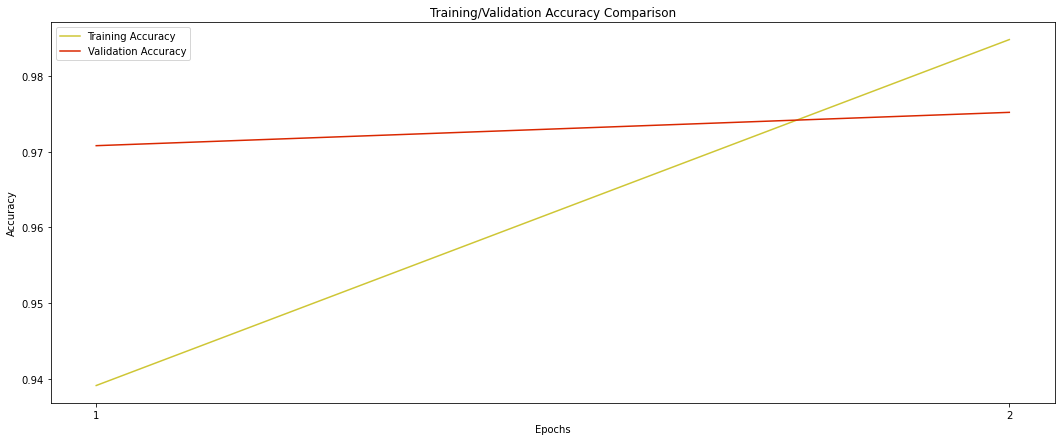

In [17]:
plot_acc_valacc(results_acc, results_val_acc)

[0.07849477604031563, 0.0705935899168253]


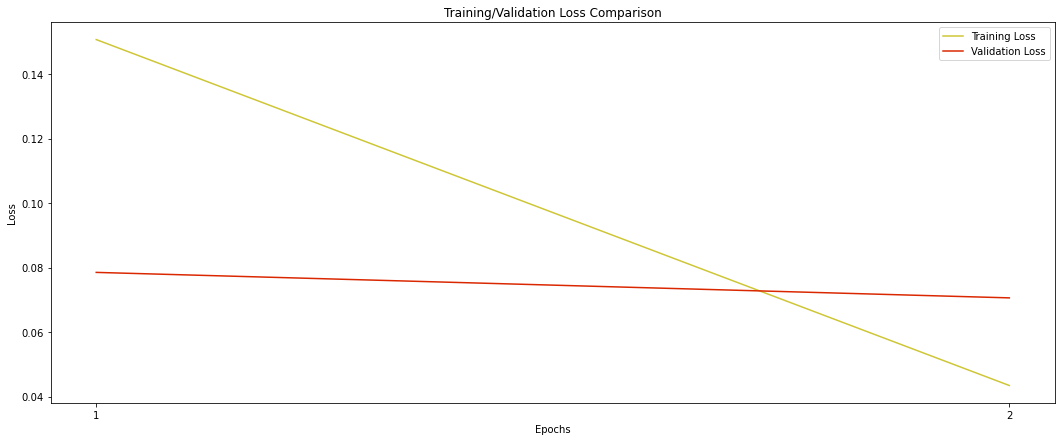

In [18]:
plot_loss_valloss(results_loss, results_val_loss)

In [19]:
model = LSTM_Model()
print(model.summary())
results = model.fit(x_train, y_train, epochs=2, batch_size=64)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 50)            5000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 5,060,501
Trainable params: 5,060,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
562/562 [==============================] - 37s 61ms/step - loss: 0.1313 - accuracy: 0.9482
Epoch 2/2
281/281 [==============================] - 2s 5ms/step - loss: 0.0699 - accuracy: 0.9763
0.06990692764520645
0.9762806296348572


D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4602
           1       0.98      0.97      0.98      4378

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



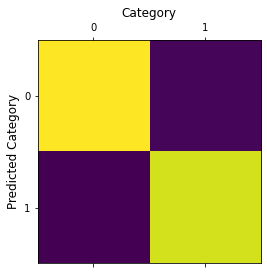

In [20]:
y_pred=model.predict_classes(x_test)

#Absolute matrix (number of guesses)
confMatrix = confusion_matrix(y_test, y_pred)
plt.matshow(confMatrix)
plt.ylabel('Predicted Category', fontsize=12)
plt.title('Category', fontsize=12)

accGraph = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]

print(classification_report(y_pred,y_test))

#### CNN Model

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
results_acc, results_val_acc, results_loss, results_val_loss = cross_validationCNN(x_train, y_train)

Epoch 1/2
421/421 [==============================] - 25s 57ms/step - loss: 0.1557 - accuracy: 0.9403 - val_loss: 0.0790 - val_accuracy: 0.9706
Epoch 2/2
421/421 [==============================] - 24s 57ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.0823 - val_accuracy: 0.9718
Epoch 1/2
421/421 [==============================] - 24s 57ms/step - loss: 0.1563 - accuracy: 0.9395 - val_loss: 0.0795 - val_accuracy: 0.9705
Epoch 2/2
421/421 [==============================] - 24s 56ms/step - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0869 - val_accuracy: 0.9689
Epoch 1/2
421/421 [==============================] - 25s 57ms/step - loss: 0.1552 - accuracy: 0.9434 - val_loss: 0.0776 - val_accuracy: 0.9704
Epoch 2/2
421/421 [==============================] - 24s 57ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.0901 - val_accuracy: 0.9692
Epoch 1/2
421/421 [==============================] - 25s 57ms/step - loss: 0.1576 - accuracy: 0.9370 - val_loss: 0.0911 - val_accuracy: 0.9681

[0.9699036180973053, 0.9705997109413147]


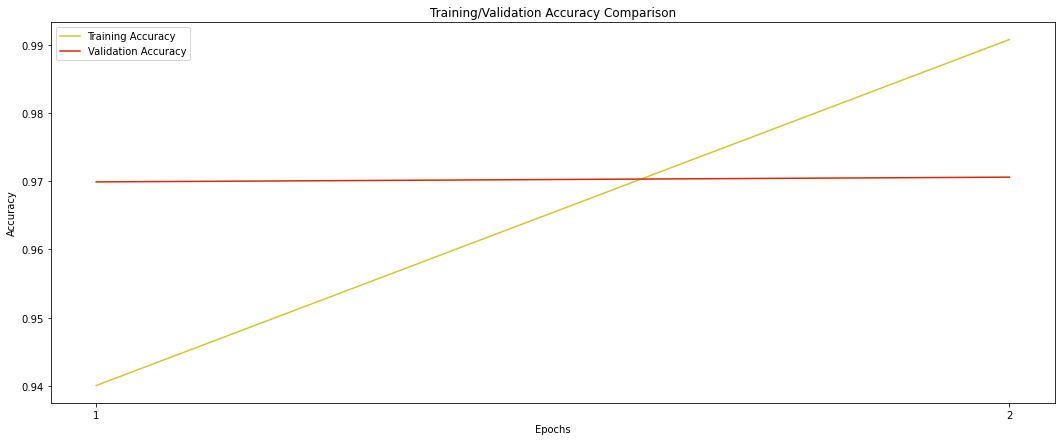

In [22]:
plot_acc_valacc(results_acc, results_val_acc)

[0.08179434388875961, 0.08617164380848408]


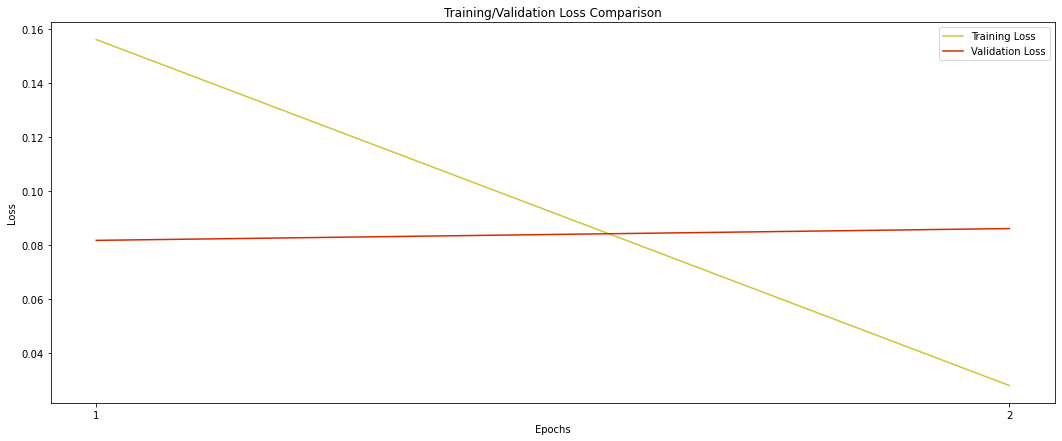

In [23]:
plot_loss_valloss(results_loss, results_val_loss)

In [24]:
model = CNN_Model()
print(model.summary())
results = model.fit(x_train, y_train, epochs=2, batch_size=64)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 50)            5000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 13, 128)           51328     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 5,067,969
Trainable params: 5,067,969
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
562/562 [==============================] - 32s 56ms/step - loss: 0.1358 - accuracy: 0.95010s - 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4666
           1       0.97      0.97      0.97      4314

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



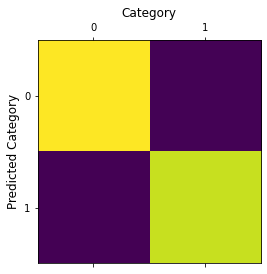

In [25]:
y_pred=model.predict_classes(x_test)

#Absolute matrix (number of guesses)
confMatrix = confusion_matrix(y_test, y_pred)
plt.matshow(confMatrix)
plt.ylabel('Predicted Category', fontsize=12)
plt.title('Category', fontsize=12)

accGraph = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]

print(classification_report(y_pred,y_test))

### Hyper-Parameter Selection

#### Learning Rate

##### LSTM Model

In [26]:
lrs=[]
acc_results = []
loss_results = []

learning_rate = 0.00025
while True:
    results_acc, results_val_acc, results_loss, results_val_loss = cross_validationLSTM(x_train, y_train, learning_rate=learning_rate)
    
    if results_val_loss[-1]>0.2:
        break

    lrs.append(learning_rate)
    acc_results.append(results_val_acc)
    loss_results.append(results_val_loss)
    learning_rate *= 2

print(lrs)
print(acc_results)
print(loss_results)

Epoch 1/2
421/421 [==============================] - 29s 64ms/step - loss: 0.2984 - accuracy: 0.8732 - val_loss: 0.1281 - val_accuracy: 0.9510
Epoch 2/2
421/421 [==============================] - 25s 59ms/step - loss: 0.1071 - accuracy: 0.9610 - val_loss: 0.0945 - val_accuracy: 0.9656
Epoch 1/2
421/421 [==============================] - 28s 60ms/step - loss: 0.3101 - accuracy: 0.8662 - val_loss: 0.1277 - val_accuracy: 0.9506
Epoch 2/2
421/421 [==============================] - 25s 59ms/step - loss: 0.1116 - accuracy: 0.9578 - val_loss: 0.1079 - val_accuracy: 0.9599
Epoch 1/2
421/421 [==============================] - 27s 60ms/step - loss: 0.3250 - accuracy: 0.8534 - val_loss: 0.1470 - val_accuracy: 0.9444
Epoch 2/2
421/421 [==============================] - 25s 59ms/step - loss: 0.1155 - accuracy: 0.9576 - val_loss: 0.1022 - val_accuracy: 0.9599
Epoch 1/2
421/421 [==============================] - 27s 60ms/step - loss: 0.3200 - accuracy: 0.8658 - val_loss: 0.1376 - val_accuracy: 0.9504

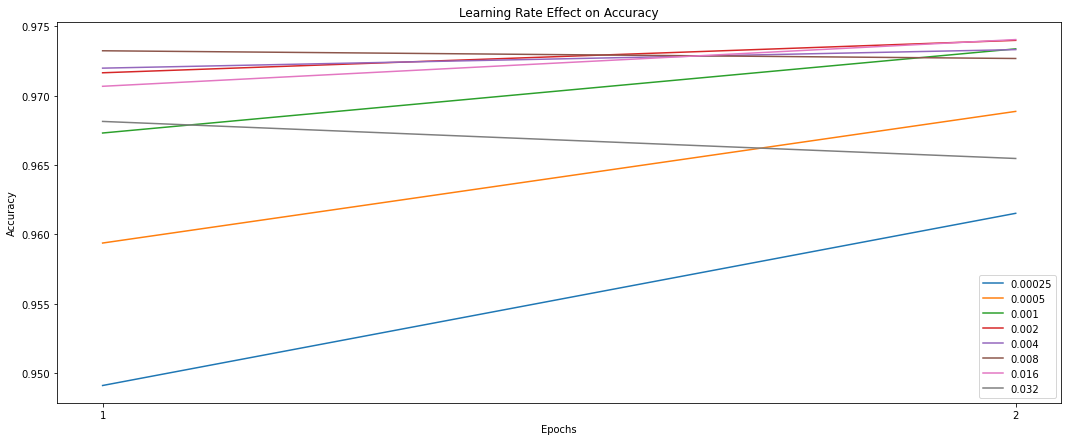

In [27]:
plt.figure(figsize = (18,7))
for r in acc_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))
    

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(lrs)
plt.title("Learning Rate Effect on Accuracy")
plt.show()

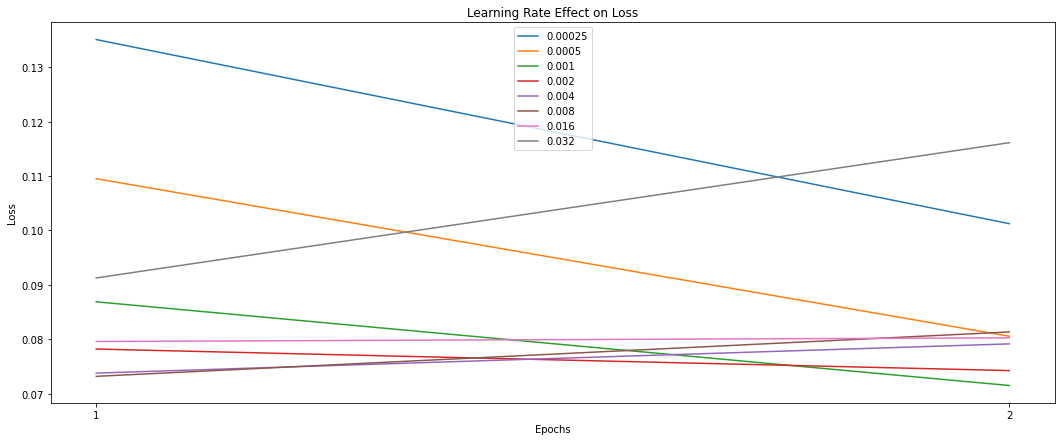

In [28]:
plt.figure(figsize = (18,7))
for r in loss_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(lrs)
plt.title("Learning Rate Effect on Loss")
plt.show()

##### CNN Model

In [29]:
lrs=[]
acc_results = []
loss_results = []

learning_rate = 0.000125
while True:
    results_acc, results_val_acc, results_loss, results_val_loss = cross_validationCNN(x_train, y_train, learning_rate=learning_rate)
    
    if results_val_loss[-1]>0.2:
        break

    lrs.append(learning_rate)
    acc_results.append(results_val_acc)
    loss_results.append(results_val_loss)
    learning_rate *= 2

print(lrs)
print(acc_results)
print(loss_results)

Epoch 1/2
421/421 [==============================] - 24s 55ms/step - loss: 0.3946 - accuracy: 0.8700 - val_loss: 0.1515 - val_accuracy: 0.9467
Epoch 2/2
421/421 [==============================] - 23s 55ms/step - loss: 0.1022 - accuracy: 0.9645 - val_loss: 0.0973 - val_accuracy: 0.9636
Epoch 1/2
421/421 [==============================] - 24s 55ms/step - loss: 0.4029 - accuracy: 0.8458 - val_loss: 0.1501 - val_accuracy: 0.9450
Epoch 2/2
421/421 [==============================] - 23s 54ms/step - loss: 0.1038 - accuracy: 0.9638 - val_loss: 0.0959 - val_accuracy: 0.9654
Epoch 1/2
421/421 [==============================] - 24s 55ms/step - loss: 0.3898 - accuracy: 0.8596 - val_loss: 0.1540 - val_accuracy: 0.9463
Epoch 2/2
421/421 [==============================] - 23s 54ms/step - loss: 0.1079 - accuracy: 0.9639 - val_loss: 0.1048 - val_accuracy: 0.9608
Epoch 1/2
421/421 [==============================] - 24s 55ms/step - loss: 0.3913 - accuracy: 0.8477 - val_loss: 0.1636 - val_accuracy: 0.9434

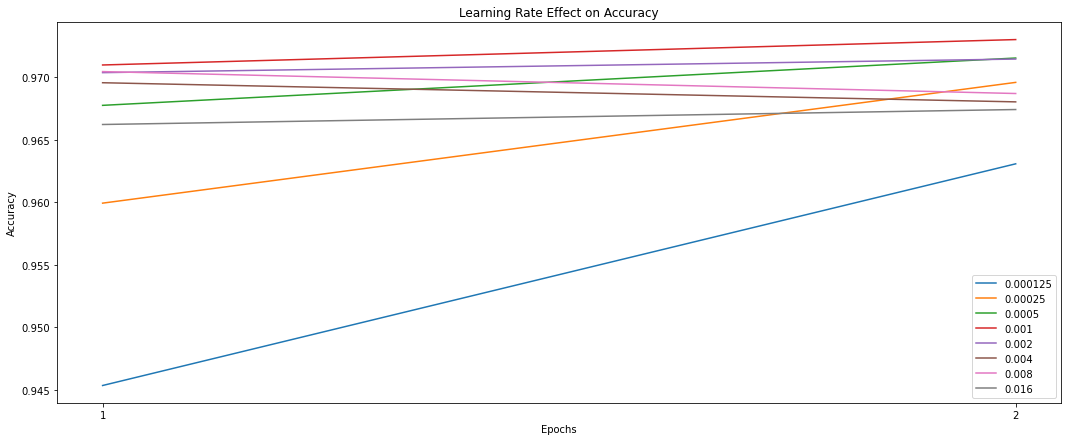

In [30]:
plt.figure(figsize = (18,7))
for r in acc_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(lrs)
plt.title("Learning Rate Effect on Accuracy")
plt.show()

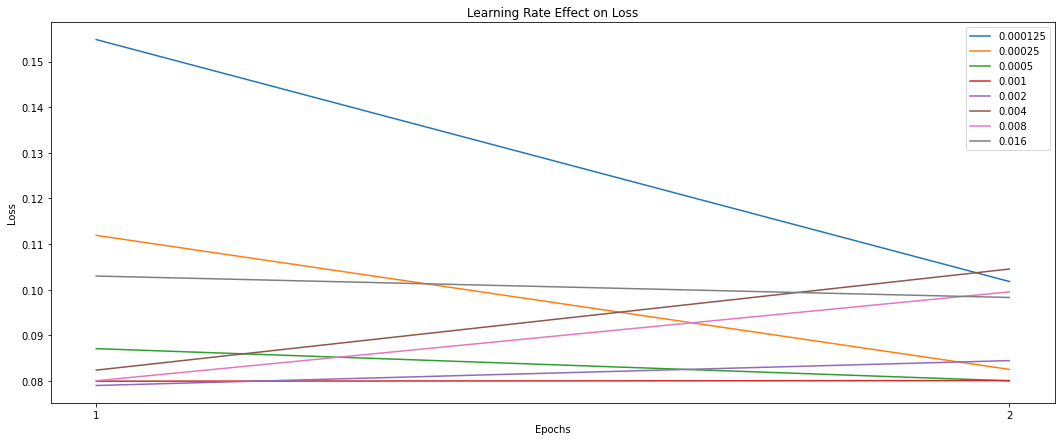

In [31]:
plt.figure(figsize = (18,7))
for r in loss_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(lrs)
plt.title("Learning Rate Effect on Loss")
plt.show()

#### Number of epochs

##### LSTM Model

In [32]:
results_acc, results_val_acc, results_loss, results_val_loss = cross_validationLSTM(x_train, y_train, n_epochs=10)

Epoch 1/10
421/421 [==============================] - 28s 62ms/step - loss: 0.1486 - accuracy: 0.9407 - val_loss: 0.0727 - val_accuracy: 0.9737
Epoch 2/10
421/421 [==============================] - 26s 61ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.0625 - val_accuracy: 0.97752 
Epoch 3/10
421/421 [==============================] - 26s 61ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.0726 - val_accuracy: 0.9763
Epoch 4/10
421/421 [==============================] - 26s 62ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0925 - val_accuracy: 0.9736
Epoch 5/10
421/421 [==============================] - 26s 61ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.1031 - val_accuracy: 0.9739
Epoch 6/10
421/421 [==============================] - 26s 61ms/step - loss: 0.0062 - accuracy: 0.9977 - val_loss: 0.1055 - val_accuracy: 0.9694
Epoch 7/10
421/421 [==============================] - 26s 61ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.1127 - val_accurac

[0.9728270024061203, 0.9760843813419342, 0.974915087223053, 0.9712399542331696, 0.9729662090539932, 0.9719639718532562, 0.9722701460123062, 0.9710729867219925, 0.9704882502555847, 0.9709059447050095]


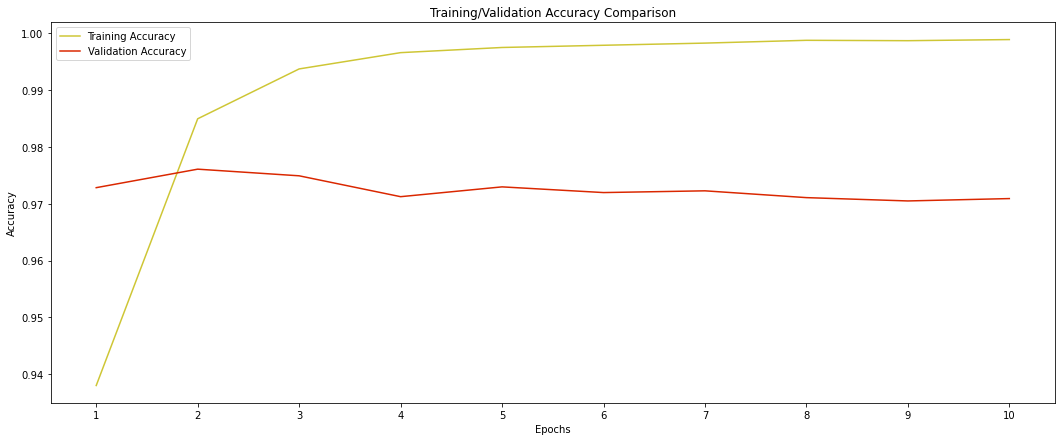

In [33]:
plot_acc_valacc(results_acc, results_val_acc)

[0.07445132173597813, 0.07071107253432274, 0.08013832941651344, 0.09651583805680275, 0.12189267575740814, 0.11948686465620995, 0.12073285691440105, 0.1306595243513584, 0.13757520355284214, 0.13025781512260437]


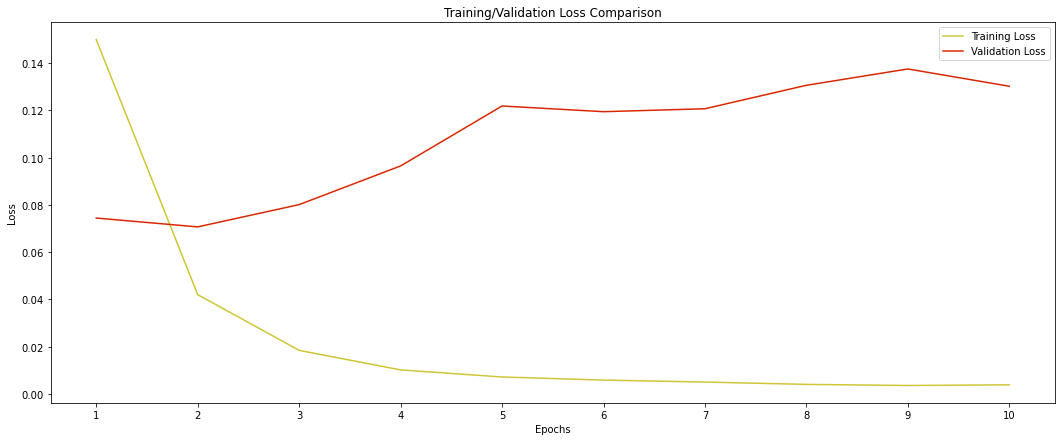

In [34]:
plot_loss_valloss(results_loss, results_val_loss)

##### CNN Model

In [35]:
results_acc, results_val_acc, results_loss, results_val_loss = cross_validationCNN(x_train, y_train, n_epochs=10)

Epoch 1/10
421/421 [==============================] - 24s 55ms/step - loss: 0.1539 - accuracy: 0.9406 - val_loss: 0.0797 - val_accuracy: 0.9717
Epoch 2/10
421/421 [==============================] - 23s 54ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0839 - val_accuracy: 0.9707
Epoch 3/10
421/421 [==============================] - 23s 54ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.1063 - val_accuracy: 0.9687
Epoch 4/10
421/421 [==============================] - 23s 55ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1134 - val_accuracy: 0.9726
Epoch 5/10
421/421 [==============================] - 23s 54ms/step - loss: 2.4508e-04 - accuracy: 1.0000 - val_loss: 0.1269 - val_accuracy: 0.9702
Epoch 6/10
421/421 [==============================] - 23s 54ms/step - loss: 1.7116e-04 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 0.9715
Epoch 7/10
421/421 [==============================] - 23s 54ms/step - loss: 3.5741e-05 - accuracy: 1.0000 - val_loss: 0.1352 - v

[0.9709058701992035, 0.9722980111837387, 0.9703769832849503, 0.9724651277065277, 0.9723537862300873, 0.9727713763713837, 0.9726321846246719, 0.9724094420671463, 0.9724094718694687, 0.9725486636161804]


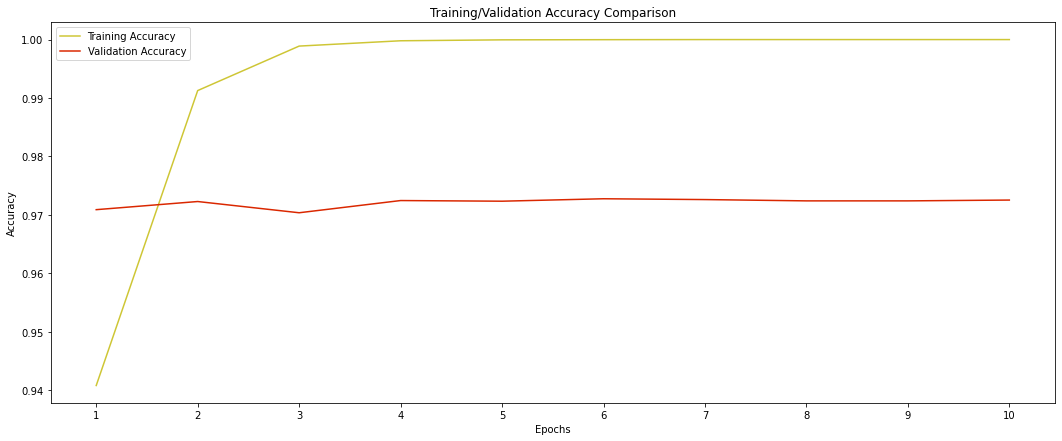

In [36]:
plot_acc_valacc(results_acc, results_val_acc)

[0.08041257783770561, 0.08087232895195484, 0.1063385121524334, 0.11289217323064804, 0.1219570692628622, 0.1284545473754406, 0.13352208212018013, 0.14016616344451904, 0.14508318156003952, 0.14933255687355995]


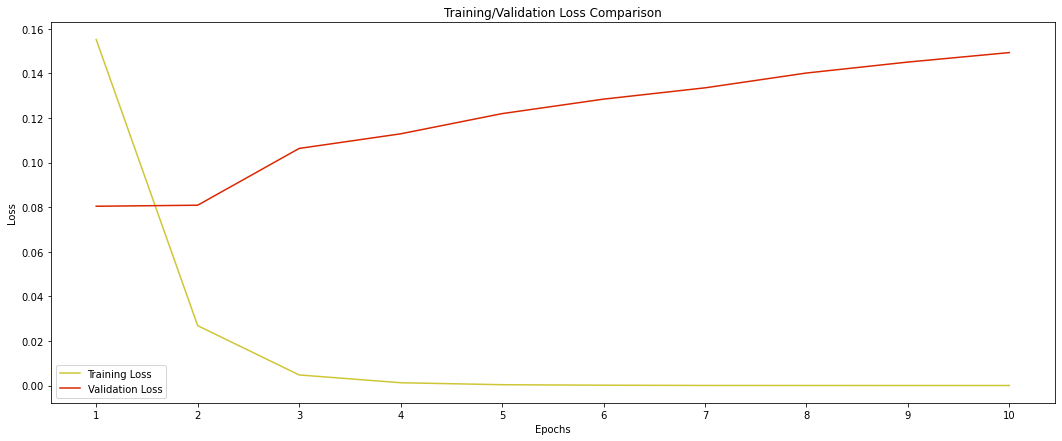

In [37]:
plot_loss_valloss(results_loss, results_val_loss)

#### Dropout Rate

##### LSTM Model

In [38]:
dropouts=[]
acc_results = []
loss_results = []

dropout = 0
while dropout<1.0:
    try:
        results_acc, results_val_acc, results_loss, results_val_loss = cross_validationLSTM(x_train, y_train, dropout=dropout)
        if results_val_loss[-1]>0.2:
            break
    except:
        break
    
    acc_results.append(results_val_acc)
    loss_results.append(results_val_loss)

    dropouts.append(dropout)
    dropout +=0.1

print(dropouts)
print(acc_results)
print(loss_results)

Epoch 1/2
421/421 [==============================] - 29s 63ms/step - loss: 0.1361 - accuracy: 0.9459 - val_loss: 0.0779 - val_accuracy: 0.9733
Epoch 2/2
421/421 [==============================] - 26s 61ms/step - loss: 0.0297 - accuracy: 0.9900 - val_loss: 0.0743 - val_accuracy: 0.9720
Epoch 1/2
421/421 [==============================] - 28s 62ms/step - loss: 0.1371 - accuracy: 0.9450 - val_loss: 0.0825 - val_accuracy: 0.9693
Epoch 2/2
421/421 [==============================] - 26s 61ms/step - loss: 0.0278 - accuracy: 0.9906 - val_loss: 0.0869 - val_accuracy: 0.9708
Epoch 1/2
421/421 [==============================] - 28s 62ms/step - loss: 0.1396 - accuracy: 0.9472 - val_loss: 0.0685 - val_accuracy: 0.9746
Epoch 2/2
421/421 [==============================] - 26s 62ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0753 - val_accuracy: 0.9752
Epoch 1/2
421/421 [==============================] - 29s 63ms/step - loss: 0.1422 - accuracy: 0.9441 - val_loss: 0.0776 - val_accuracy: 0.9716

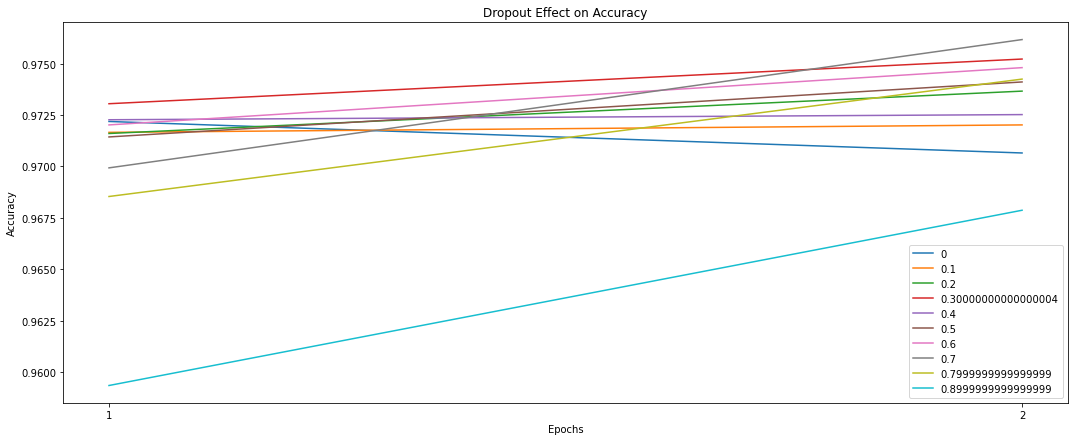

In [39]:
plt.figure(figsize = (18,7))
for r in acc_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(dropouts)
plt.title("Dropout Effect on Accuracy")
plt.show()

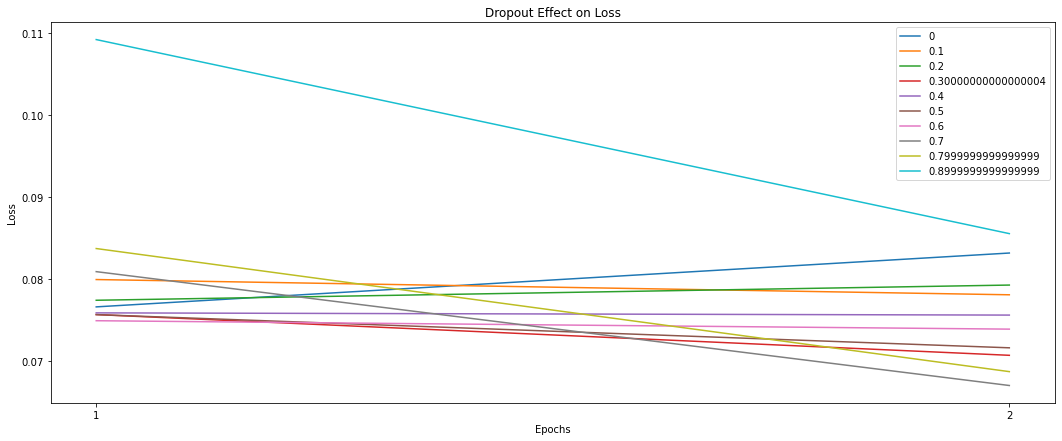

In [40]:
plt.figure(figsize = (18,7))
for r in loss_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(dropouts)
plt.title("Dropout Effect on Loss")
plt.show()

#### Kernel Size

##### CNN Model

In [41]:
kss=[]
acc_results = []
loss_results = []

kernel_size = 2
while kernel_size<10:
    try:
        results_acc, results_val_acc, results_loss, results_val_loss = cross_validationCNN(x_train, y_train, kernel_size=kernel_size)
    except:
        break
    
    if results_val_loss[-1]>0.2:
        break

    kss.append(kernel_size)
    acc_results.append(results_val_acc)
    loss_results.append(results_val_loss)
    kernel_size +=1

print(kss)
print(acc_results)
print(loss_results)

Epoch 1/2
421/421 [==============================] - 24s 54ms/step - loss: 0.1851 - accuracy: 0.9212 - val_loss: 0.0907 - val_accuracy: 0.9653
Epoch 2/2
421/421 [==============================] - 23s 54ms/step - loss: 0.0357 - accuracy: 0.9876 - val_loss: 0.0823 - val_accuracy: 0.9699
Epoch 1/2
421/421 [==============================] - 23s 54ms/step - loss: 0.1830 - accuracy: 0.9194 - val_loss: 0.0872 - val_accuracy: 0.9673
Epoch 2/2
421/421 [==============================] - 23s 54ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.0781 - val_accuracy: 0.9694
Epoch 1/2
421/421 [==============================] - 24s 55ms/step - loss: 0.1846 - accuracy: 0.9248 - val_loss: 0.0880 - val_accuracy: 0.9673
Epoch 2/2
421/421 [==============================] - 23s 54ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.0789 - val_accuracy: 0.9719
Epoch 1/2
421/421 [==============================] - 24s 54ms/step - loss: 0.1827 - accuracy: 0.9271 - val_loss: 0.0854 - val_accuracy: 0.9699

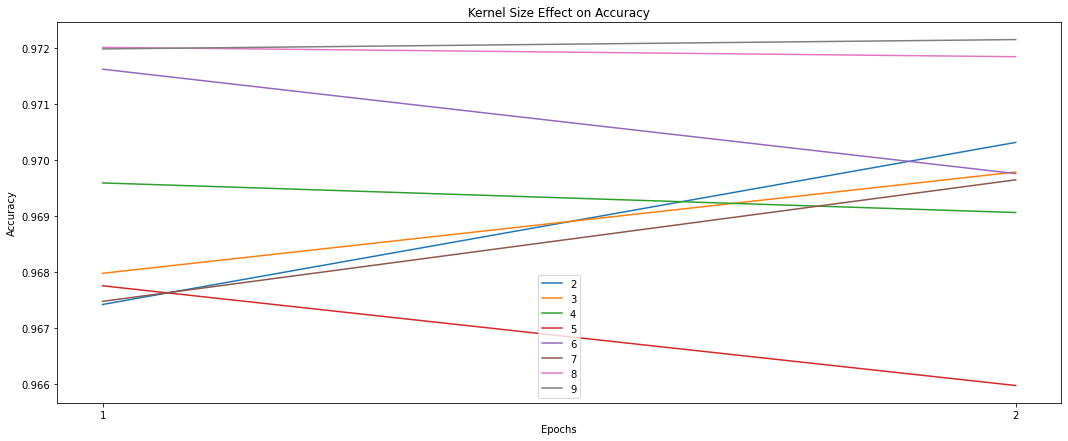

In [42]:
plt.figure(figsize = (18,7))
for r in acc_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(kss)
plt.title("Kernel Size Effect on Accuracy")
plt.show()

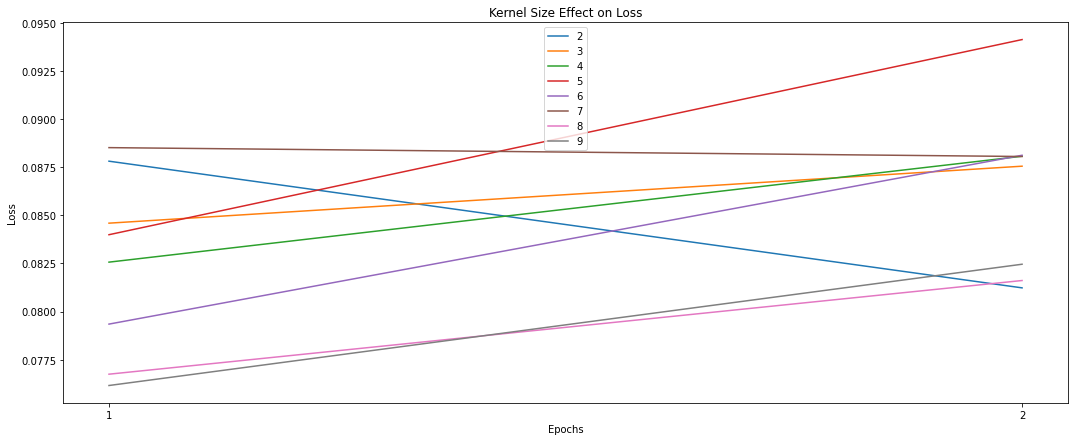

In [43]:
plt.figure(figsize = (18,7))
for r in loss_results:
    plt.plot(range(1, len(r)+1), r)
    plt.xticks(range(1, len(r)+1))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(kss)
plt.title("Kernel Size Effect on Loss")
plt.show()